# Example 3

This is an example that reproduces Figures 2,3 from M Genkin, O Hughes, TA Engel ArXiv 2020.
We generate synthetic data from a ramping model (with linear potential), visualise the generated spikes and latent trajectory, and optimize a model on the generated data under different assumptions.

In [1]:
import neuralflow
import numpy as np
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec
from neuralflow.utilities.visualization_functions import plot_spikes, plot_fitting_results
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Step 1: Generate synthetic data

1) Specify the ground-truth model for data generation, see the implementation of the `EnergyModel` class for available options. As described in the paper, we generate the data from ramping model, with noise magnitude $D=0.56$, and narrow zero-centered initial distribution of the latent states. We use absorbing boundary mode so that each trial ends at the boundary. All these parameters are specified at the initialization of EnergyModel class.

2) Specify additional data generation parameters. Here we will generate 200 trials of data, each trial will have 100 seconds maximum duration (however, all of them will terminate earlier due to absorption at the decision boundary, with the average trial duration time less than 1 second). We will use time step `deltaT = 0.0001` for the Euler–Maruyama numerical integration of the Langevin equation. We also set the parameter `last_event_is_spike` to False in order to record the trial termination time.  

3) Perform data generation

4) (OPTIONAL) Visualize latent trajectories and spike rasters of the generated data. First of all, for each of the 200 generated latent trajectories, find the termination side (left or right boundary). Select 3 example trials where the latent trajectory terminated on the left, and 6 trials where the latent trajectory terminated on the right boundary. Plot latent trajectories and the corresponding spike rasters for the example nine trials.

In [14]:
EnergyModelParams={'pde_solve_param':{'method':{'name': 'SEM', 'gridsize': {'Np': 8, 'Ne': 64}}}, 
               'Nv': 447,  
               'peq_model':{"model": "linear_pot", "params": {"slope": -2.65}},
               'D0': 0.56,
               'p0_model':{"model": "single_well", "params": {"miu": 200, "xmin": 0}},
               'boundary_mode':'absorbing', 
               'num_neuron':1,
               'firing_model':[{"model": "linear", "params": {"r_slope": 50, "r_bias": 60}}],
               'verbose':True
               }
em_gt=neuralflow.EnergyModel(**EnergyModelParams)

data_gen_params={'deltaT':0.0001, 'time_epoch':  [(0,100)]*200, 'last_event_is_spike':False}

spikes, time_bins, diff_traj, metadata=em_gt.generate_data(**data_gen_params)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 12.01it/s]


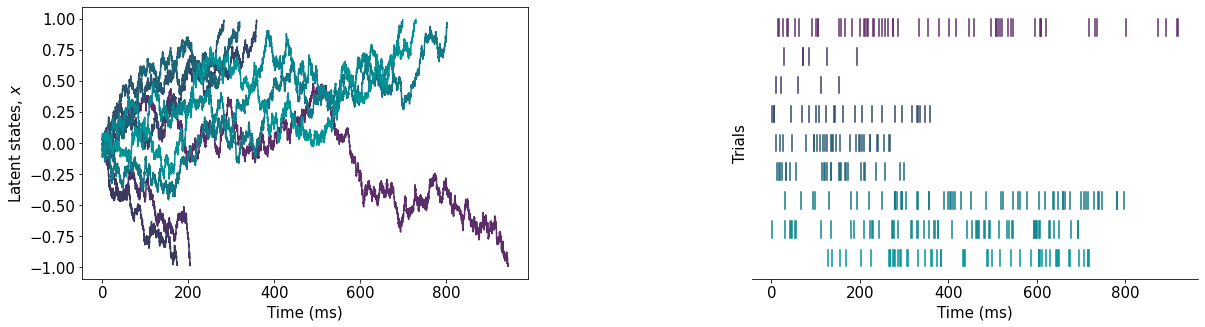

In [15]:
#(OPTIONAL): Visualize the latent trajectories and spike rasters of the generated data
fig=plt.figure(figsize=(20,5))
gs=gridspec.GridSpec(1,2,wspace=0.5)
colors=[[0, 0.5804, 0.5922], [0.0353, 0.5216, 0.5569], [0.0667, 0.4745, 0.5255],
[0.1137, 0.4000, 0.4784], [0.1569, 0.3373, 0.4353], [0.1922, 0.2706, 0.4000],
[0.2275, 0.2235, 0.3686], [0.2824, 0.2000, 0.3922], [0.3608, 0.1804, 0.4118]]
colors.reverse()



#Find where each of the latent trajectories teminate (1 if the right boundary, -1 if the left boundary):
bnd=np.array([1 if diff_traj[i][-1]>0 else -1 for i in range(len(data_gen_params['time_epoch']))])

# Take 3 example trajectories that terminate on the left boundary, and 6 that terminate on the right boundary
if np.where(bnd==-1)[0].size<3:
    print('Due to bad luck there are less than 3 trials out of 200 that terminate on the left boundary. Please rerun the previous cell to generate new data, and then rerun this cell')
traj_indeces=np.concatenate((np.where(bnd==-1)[0][:3],np.where(bnd==1)[0][:6]))

#Plot latent trajectories
ax = plt.subplot(gs[0])
for i in range(9):
    plt.plot(time_bins[traj_indeces[i]]*1000,diff_traj[traj_indeces[i]],color=colors[i])
plt.xlabel('Time (ms)',fontsize=15)
plt.ylabel(r'Latent states, $x$',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = plt.subplot(gs[1])

#Plot spikes
plot_spikes(spikes[list(traj_indeces)],ax,colors)

plt.xlabel('Time (ms)',fontsize=15)
plt.ylabel('Trials',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

The code above should produce the following image:
![Fig3_1](Example3_1.png)

## Step 2: Optimize model potential using the generated data under the correct assumptions

1) Specify the EnergyModel variable for fitting. All parameters are the same as the ground-truth, but the initial guess for potential is the constant potential (uniform peq model). To accelerate the evaluation of this cell, we also reduce grid resolution.

2) Specify options. Here we want to optimize the model with the correct assumptions: absorbing boundary mode, with the correct p0 distribution, and with the absorption operator (`absorption_event=True`). To accelerate computation time, we set max_iteration to 50, however, you may want to increase it.

3) Optimize the model with the selected parameters.

4) Visualise the results.

In [16]:
EnergyModelParams={'pde_solve_param':{'method':{'name': 'SEM', 'gridsize': {'Np': 8, 'Ne': 16}}}, 
               'Nv': 111,  
               'peq_model':{"model": "uniform", "params": {}},
               'D0': 0.56,
               'p0_model':{"model": "single_well", "params": {"miu": 200, "xmin": 0}},
               'boundary_mode':'absorbing', 
               'num_neuron':1,
               'firing_model':[{"model": "linear", "params": {"r_slope": 50, "r_bias": 60}}],
               'verbose':True
               }
em_fit=neuralflow.EnergyModel(**EnergyModelParams)

options={}
options['data']={'dataTR':spikes}
options['save']=None
options['inference']={'metadataTR':{'last_event_is_spike':False,'absorption_event':True}}
options['optimization']={'gamma':{'F':0.005},'max_iteration':50,'loglik_tol':0,'etaf':0}

em_fit.fit('GD',options);

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.18s/it]


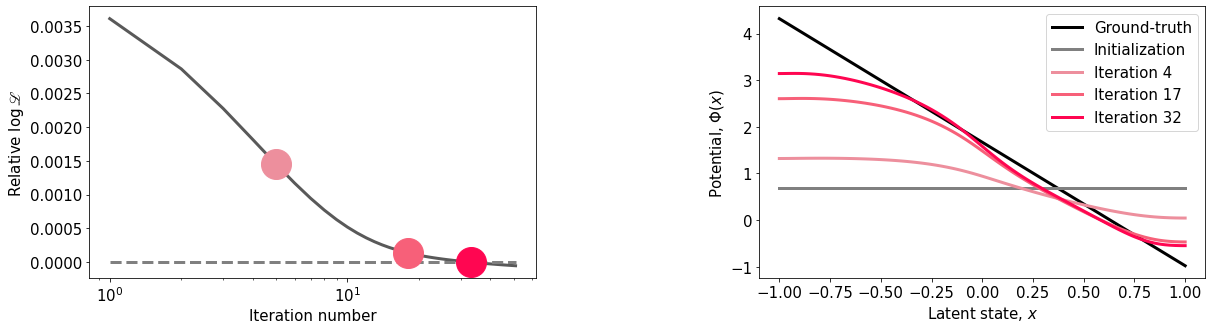

In [17]:
#Visualise the results
fig=plt.figure(figsize=(20,5))
gs=gridspec.GridSpec(1,2,wspace=0.5)
colors=[[0.9294, 0.5608, 0.6157], [0.9686, 0.3765, 0.4745], [1.0000, 0.0235, 0.3176]]

#Plot the loglikelihood on iterations 4,17 and the one where fitted loglik matches the ground-truth one
ll_gt=em_gt.score(options['data']['dataTR'],metadata=options['inference']['metadataTR'])
rel_lls = (ll_gt-em_fit.iterations_GD_['logliks'])/ll_gt
example_iterations=[4,17,np.where(rel_lls<0)[0][0] if np.where(rel_lls<0)[0].size>0 else rel_lls.size-1]
plot_fitting_results(gs[0],gs[1],em_fit,em_gt,options,example_iterations,colors)

The code above should produce the following image:
![Fig3_2](Example3_2.png)

## Step 3: Optimize model potential on the same data under different assumptions

1) Same as in Step 2, but without absorption operator.

2) Same as in Step 2, but with reflective boundary conditions (and without absorption operator).

3) Same as in Step 2, but with reflective boundary conditions, and starting from equilibirum probability distribution density of the latent states.

Visualise the results. Note that in the M. Genkin et. al. 2020 ArXiv paper Figure 3 was generated under slightly different ground-truth model parameters, so that the position of the ground-truth loglikelihood (dashed line) can differ. However, the spurious features of the potential are qualitatively similar to the figure in the paper. 



Starting optimization 1 (no absorption operator)...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.13s/it]


Starting optimization 2 (no absorption operator, reflecting BCs)...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.12s/it]


Starting optimization 3 (no absorption operator, reflecting BCs, trials start at equilibrium)...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.12s/it]


Text(0.5, 0.27, 'No absorption operator, reflecting BCs, trials start at equilibrium')

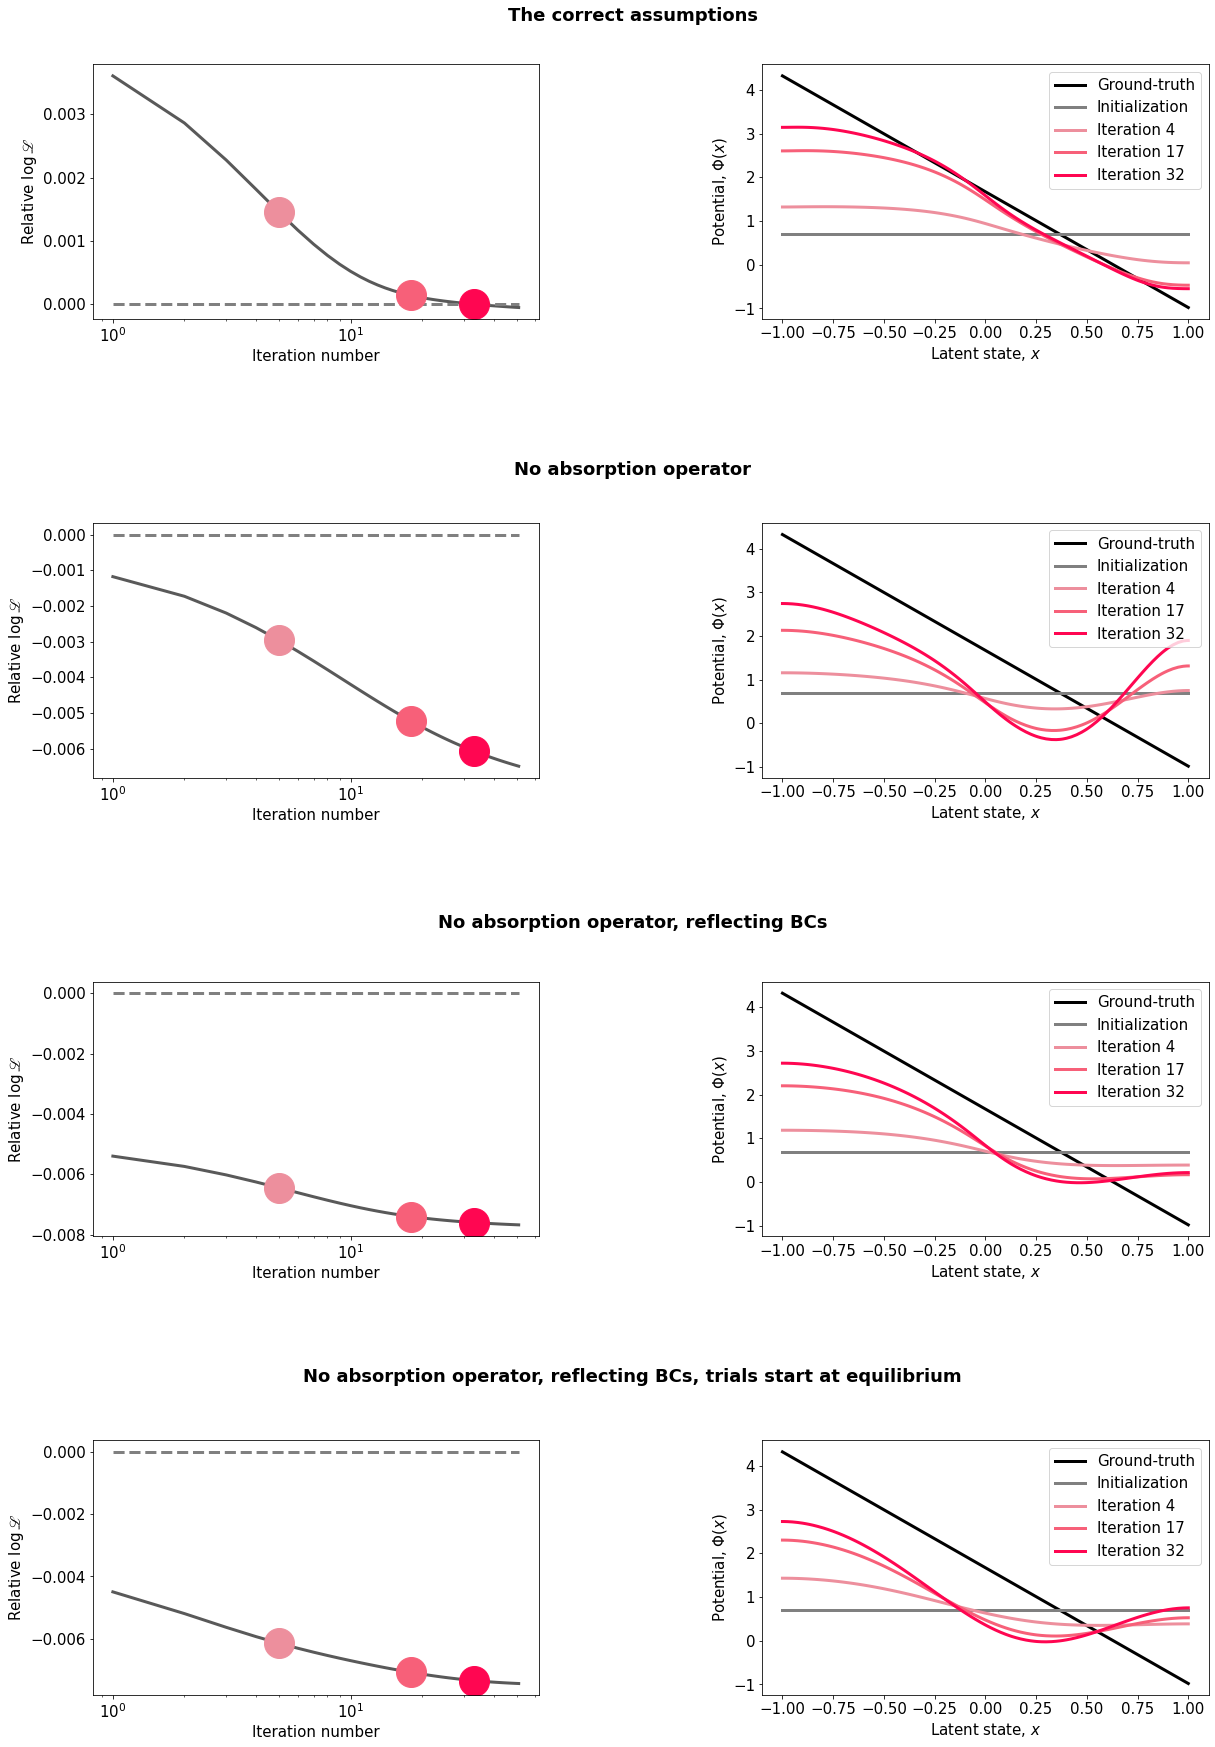

In [18]:
#Create a big figure to plot all the results
fig=plt.figure(figsize=(20,30))
gs=gridspec.GridSpec(4,2,wspace=0.5,hspace=0.8);
#Plot the results from the previous cell
plot_fitting_results(gs[0],gs[1],em_fit,em_gt,options,example_iterations,colors)
fig.text(0.5,0.9,'The correct assumptions',fontsize=18,horizontalalignment='center',fontweight='bold')

#Optimize the model without the absorption operator
options['inference']['metadataTR']['absorption_event']=False
print('Starting optimization 1 (no absorption operator)...')
em_fit=neuralflow.EnergyModel(**EnergyModelParams)
em_fit.fit('GD',options)
plot_fitting_results(gs[2],gs[3],em_fit,em_gt,options,example_iterations,colors)
fig.text(0.5,0.69,'No absorption operator',fontsize=18,horizontalalignment='center',fontweight='bold')

EnergyModelParams['boundary_mode']='reflecting'
print('Starting optimization 2 (no absorption operator, reflecting BCs)...')
em_fit=neuralflow.EnergyModel(**EnergyModelParams)
em_fit.fit('GD',options)
plot_fitting_results(gs[4],gs[5],em_fit,em_gt,options,example_iterations,colors)
fig.text(0.5,0.48,'No absorption operator, reflecting BCs',fontsize=18,horizontalalignment='center',fontweight='bold')

EnergyModelParams['p0_model']=None
print('Starting optimization 3 (no absorption operator, reflecting BCs, trials start at equilibrium)...')
em_fit=neuralflow.EnergyModel(**EnergyModelParams)
em_fit.fit('GD',options)
plot_fitting_results(gs[6],gs[7],em_fit,em_gt,options,example_iterations,colors)
fig.text(0.5,0.27,'No absorption operator, reflecting BCs, trials start at equilibrium',fontsize=18,horizontalalignment='center',fontweight='bold')

The code above should produce the following image:
![Fig3_3](Example3_3.png)